<a href="https://colab.research.google.com/github/bobadams1/land_use_google_earth_engine/blob/main/land_use_categorization_of_GEE_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm.notebook import tqdm

# Pytorch
import torch
import torchvision
import torchsummary
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import random
SEED = 2187
np.random.seed(SEED)

Sourcing Training Data from https://github.com/phelber/EuroSAT

This dataset contains 27000 georeferenced images categorized by land usage across 10 classes

In [5]:
!wget https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1 -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2023-08-17 15:26:17--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  90.27M   622KB/s    in 2m 13s  

2023-08-17 15:28:31 (697 KB/s) - ‘EuroSAT.zip’ saved [94658721/94658721]



Traning Data EDA

AnnualCrop


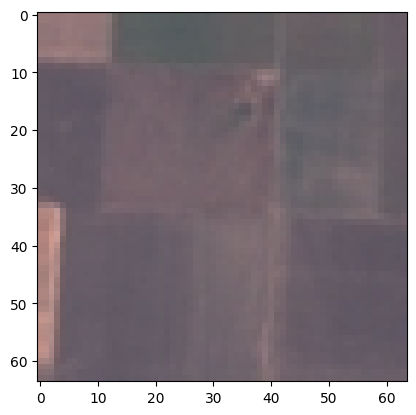

In [29]:
# !ls EuroSAT/EuroSAT_RGB/AnnualCrop/
i=0
j=1

base_path = 'EuroSAT/EuroSAT_RGB/'
category_list = ['AnnualCrop', 'HerbaceousVegetation', 'Industrial', 'PermanentCrop', 'River',
'Forest', 'Highway', 'Pasture', 'Residential', 'SeaLake']
image_path = f'{category_list[i]}_{j}.jpg'

img = Image.open(base_path + '/' + category_list[i] + "/" + image_path)
print(category_list[i])
plt.imshow(img);

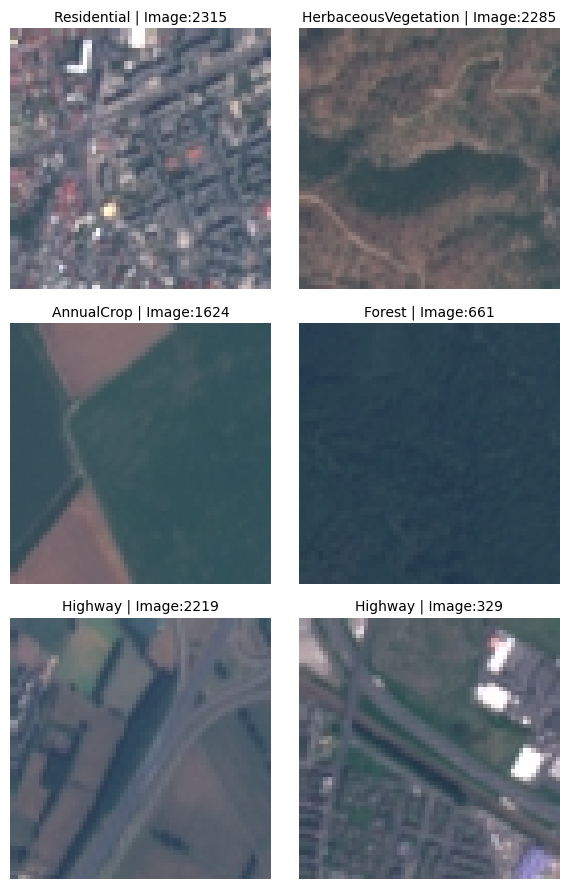

In [90]:
# Random Images from all classes
image_count = 6
cols = 2
rows = image_count // cols

fig, ax = plt.subplots(rows, cols, figsize = ((cols*3),((rows) *3)))

for n in range(image_count):
  i = np.random.choice(range(0,10))
  j_range = len(os.listdir(base_path + '/' + category_list[i] + '/'))
  j = np.random.choice(range(1, j_range +1))
  # print(category_list[i], " | Image:",j)

  img = Image.open(base_path + '/' + category_list[i] + "/" + category_list[i] + "_" + str(j) + ".jpg")
  ax[n % rows, n//rows].axis('off')
  ax[n % rows, n//rows].set_title(f"{category_list[i]} | Image:{j}", fontsize = 10)
  ax[n % rows, n//rows].imshow(img)
plt.tight_layout()

Load the Dataset

In [91]:
class EuroSat(data.Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    if self.transform:
      x = self.transform(dataset[index][0])
    else:
      x = dataset[index][0]

    y = dataset[index][1]
    return x, y

  def __len__(self):
    return len(dataset)

ImageNet Normalization

https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670/2

In [92]:
image_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [102]:
data_dir = 'EuroSAT/EuroSAT_RGB/'
dataset = datasets.ImageFolder(data_dir)

class_names = dataset.classes

print(f"{len(class_names)} total classes available in the dataset, comprising:\n",', '.join(class_names))
print()


10 total classes available in the dataset, comprising:
 AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake



Apply Transformations, Normalizations and Train-Test Split

In [107]:
train_data = EuroSat(dataset, train_transform)
test_data = EuroSat(dataset, test_transform)

train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices = indices[:split])
test_data = data.Subset(test_data, indices = indices[split:])

print(f"{len(train_data)} training images")
print(f"{len(test_data)} testing images")

21600 training images
5400 testing images


Dataloader for Pytorch

In [ ]:
num_workers = 2
batch_size = 16

train_dataloader = data.DataLoader(train_data,
                                   batch_size = batch_size,
                                   shuffle = True,
                                   num_workers = num_workers
                                   )
test_dataloader = data.DataLoader(test_data,
                                  batch_size = batch_size,
                                  shuffle = False,
                                  num_workers = num_workers)